In [1]:
import os
from pathlib import Path
import sys
import numpy as np
import scvelo as scv

In [2]:
notebook_dir = os.getcwd()
notebook_dir

'c:\\Users\\OmerCagatayTalikaci\\Desktop\\github\\STVelo\\notebooks\\pipeline_control'

In [6]:
Path(notebook_dir).parents[2]

WindowsPath('c:/Users/OmerCagatayTalikaci/Desktop/github')

In [5]:
os.chdir(Path(notebook_dir).parents[2])

In [9]:
pipeliens_path = os.path.join(os.getcwd(),'STVelo','stvelo','pipelines')

In [12]:
sys.path.append(pipeliens_path)

In [16]:
# import sys  
# sys.path.insert(1,'/home/sergio/Jnotebooks/SALMON/github_repo/SALMON/stvelo/')

In [14]:
from simulate_3ode import *

# Simulation

In [15]:
mu = np.array([3, 1.8, 0.8, 0.5])

R = np.array([[.16, .128, .08, .032],
              [.128, .16 , .08, .032],
              [.08, .08, .16 , .08],
              [.032 ,.032 , .08 , .16]])

C = np.array([0.4, 0.4, 0.4, 0.4])[:, None]

cov = C * R
cov=np.log(cov)
alpha, beta , nu, gamma = np.exp(np.random.multivariate_normal(mu, cov, size = 300).T)

In [16]:
def switch_times(t_max, n_vars):
    lower_bound = 0.05 * t_max
    upper_bound = 0.8 * t_max

    
    uniform_array = np.random.uniform(lower_bound, upper_bound, n_vars)

    return uniform_array

In [17]:
s = switch_times(20,300)

In [18]:
adata_dict = simulation_3ode(n_obs=800,alpha=alpha, beta= beta, nu=nu, gamma=gamma, t_max=20, switches=s/20,n_vars=300)

In [23]:
adata_dict['adata_n_c'].layers['unspliced']

(800, 300)

# Preprocessing

In [23]:
from pipelines.preprocessing import Preprocessing

In [24]:
config = {
'preprocess_params': {
    'min_counts': 200,
    'min_cells': 5,
    'n_neighbors': 23,
    'n_pcs': 0,
    'min_dist': 1,
    # 'resolution': 0.8
},
'functions_to_apply': {
    'filter_cells': True,
    'filter_genes': True,
    'normalize_total': True,
    'log1p': True,
    'pca': True,
    'neighbors': True,
    'umap': True,
    'leiden': True,
    'moments': True
}
}

In [25]:
for key, adata in adata_dict.items():
    print(f'{key} is being preprocessed.')
    preprocessor = Preprocessing(adata,config)
    adata = preprocessor.preprocess_data()

adata_s_u is being preprocessed.


2024-09-17 08:50:36.683921: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
adata_n_c is being preprocessed.
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [24]:
adata_dict

{'adata_s_u': AnnData object with n_obs × n_vars = 800 × 300
     obs: 'true_t'
     var: 'true_t_', 'true_alpha', 'true_beta', 'true_nu', 'true_gamma', 'true_scaling'
     layers: 'unspliced', 'spliced',
 'adata_n_c': AnnData object with n_obs × n_vars = 800 × 300
     obs: 'true_t'
     var: 'true_t_', 'true_alpha', 'true_beta', 'true_nu', 'true_gamma', 'true_scaling'
     layers: 'unspliced', 'spliced'}

# Velocities

In [28]:
from pipelines.compute_velocity import Velocities

In [ ]:
# config = {
#     'velocity_types': ['deterministic', 'stochastic', 'dynamical', 'velovi']
# }

In [55]:
config = {
    'velocity_types': ['dynamical','deterministic','stochastic']
}

In [56]:
velocity_computer = Velocities(adata_dict,config)

Using device: cpu


In [57]:
adata_dict_velocity = velocity_computer.compute_velocities()

recovering dynamics (using 8/32 cores)


  0%|          | 0/222 [00:00<?, ?gene/s]

Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0


    finished (0:00:11) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/32 cores)


  0%|          | 0/799 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/32 cores)


  0%|          | 0/799 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/32 cores)


  0%|          | 0/799 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
recovering dynamics (using 8/32 cores)


  0%|          | 0/229 [00:00<?, ?gene/s]

    finished (0:00:07) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/32 cores)


  0%|          | 0/799 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/32 cores)


  0%|          | 0/799 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/32 cores)


  0%|          | 0/799 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [64]:
scv.tl.velocity_graph(adata_dict_velocity['adata_n_c_dynamical'])

computing velocity graph (using 1/32 cores)


  0%|          | 0/799 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


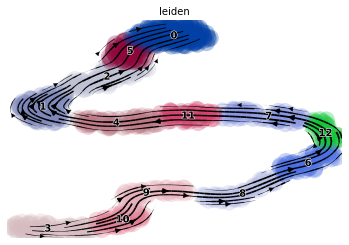

In [60]:
scv.pl.velocity_embedding_stream(adata_dict_velocity['adata_n_c_dynamical'], basis='umap',color='leiden')

# Save results

In [65]:
saving_path='/home/sergio/Jnotebooks/SALMON/datasets/simulated_data/'

In [66]:
for d in adata_dict_velocity.keys():
    print(d)
    adata_dict_velocity[d].write(os.path.join(saving_path,d+'.h5ad'))

adata_s_u_dynamical
adata_s_u_deterministic
adata_s_u_stochastic
adata_n_c_dynamical
adata_n_c_deterministic
adata_n_c_stochastic
